In [1]:


import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from typing import Optional, Tuple, Set


 # Including sprite-render helper and WareHouse deterministic env functions from Assignment 1


def _circle_sprite(rgb, fill_alpha=1.0, edge_rgb=(0,0,0)):
    s = np.zeros((8,8,4), float); cx=3.5; cy=3.5
    for r in range(8):
        for c in range(8):
            d = ((r-cx)**2 + (c-cy)**2)**0.5
            if d <= 3.2: s[r,c,:3]=rgb; s[r,c,3]=fill_alpha
            if 2.9 < d <= 3.5: s[r,c,:3]=edge_rgb; s[r,c,3]=1.0
    return s

def _square_sprite(rgb, alpha=1.0):
    s = np.zeros((8,8,4), float); s[:,:,:3]=rgb; s[:,:,3]=alpha; return s

_S_AGENT_IDLE  = _circle_sprite((0.90, 0.10, 0.10))
_S_AGENT_CARRY = _circle_sprite((0.95, 0.55, 0.10))
_S_SHELF   = _square_sprite((0.15, 0.15, 0.15), 1.0)
_S_PICKUP  = _square_sprite((0.20, 0.70, 0.30), 0.95)
_S_DROPOFF = _square_sprite((0.20, 0.45, 0.90), 0.95)

def _background_texture(n: int):
    bg = np.zeros((n,n,4), float)
    for r in range(n):
        for c in range(n):
            shade = 0.84 if (r+c)%2==0 else 0.90
            dx = (r - (n-1)/2)/n; dy = (c - (n-1)/2)/n
            vign = 0.08*(dx*dx + dy*dy)
            bg[r,c,:3] = max(0.0, shade - vign); bg[r,c,3] = 1.0
    return bg

def render_grid_sprites(n: int, agent: Tuple[int,int], carrying: bool,
                        shelves: Set[Tuple[int,int]], pickup: Tuple[int,int],
                        dropoff: Tuple[int,int], title: str = ""):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(_background_texture(n), extent=[0,n,0,n], origin="lower", interpolation="nearest")

    def put(sprite, r, c):
        ax.imshow(sprite, extent=[c,c+1,r,r+1], origin="lower", interpolation="nearest", zorder=3)

    for (sr, sc) in shelves: put(_S_SHELF, sr, sc)
    pr, pc = pickup;  put(_S_PICKUP, pr, pc)
    dr, dc = dropoff; put(_S_DROPOFF, dr, dc)

    ar, ac = agent
    put(_S_AGENT_CARRY if carrying else _S_AGENT_IDLE, ar, ac)

    ax.set_xticks(np.arange(0, n+1, 1)); ax.set_yticks(np.arange(0, n+1, 1))
    ax.grid(which='both', color='black', linewidth=0.5, alpha=0.4)
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.set_xlim(0,n); ax.set_ylim(0,n); ax.set_title(title)
    plt.show()

#  WarehouseDeterministicEnv class (from thhe Assignment 1)


class WarehouseDeterministicEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self,
                 grid_size: int = 6,
                 shelves: Optional[Set[Tuple[int,int]]] = None,
                 pickup: Tuple[int,int] = (0,0),
                 dropoff: Tuple[int,int] = (5,5),
                 max_steps: int = 300):
        super().__init__()
        self.n = grid_size
        self.shelves = set(shelves or {(2,2),(2,3),(3,2)})
        self.pickup = pickup
        self.dropoff = dropoff
        self.max_steps = max_steps

        self.action_space = spaces.Discrete(6)
        self.observation_space = spaces.Discrete(self.n*self.n*2)

        self.agent = (0,0)
        self.carrying = False
        self.steps = 0
        self._picked_once = False

    def _obs_id(self, pos: Tuple[int,int], carrying: bool) -> int:
        r, c = pos
        return (r*self.n + c) + (self.n*self.n if carrying else 0)

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.agent = (0,0)
        self.carrying = False
        self.steps = 0
        self._picked_once = False
        return self._obs_id(self.agent, self.carrying), {}

    def step(self, action: int):
        r, c = self.agent
        reward = -1.0
        terminated = False
        truncated = False

        if action in (0,1,2,3):
            dr, dc = {0:(-1,0), 1:(1,0), 2:(0,-1), 3:(0,1)}[action]
            nr, nc = r+dr, c+dc
            if 0 <= nr < self.n and 0 <= nc < self.n and (nr,nc) not in self.shelves:
                self.agent = (nr, nc)
            else:
                reward += -20.0
        elif action == 4:  # Pick
            if self.agent == self.pickup and not self.carrying:
                self.carrying = True
                if not self._picked_once:
                    reward += 25.0
                    self._picked_once = True
        elif action == 5:  # Drop
            if self.agent == self.dropoff and self.carrying:
                reward += 100.0
                terminated = True
            elif self.agent != self.dropoff:
                reward += -10.0
                print("Wrong drop off")

        self.steps += 1
        if self.steps >= self.max_steps:
            truncated = True

        obs = self._obs_id(self.agent, self.carrying)
        return obs, reward, terminated, truncated, {}

    def render(self):
        render_grid_sprites(
            n=self.n, agent=self.agent, carrying=self.carrying,
            shelves=self.shelves, pickup=self.pickup, dropoff=self.dropoff,
            title=f"Deterministic | agent={self.agent} | carrying={self.carrying}"
        )



env_dqn = WarehouseDeterministicEnv()
state_size = env_dqn.observation_space.n
action_size = env_dqn.action_space.n
print(f"State space: {state_size}, Action space: {action_size}")


State space: 72, Action space: 6


In [3]:
def one_hot_state_vector(state_idx, total_states):
    v = torch.zeros(total_states)
    v[state_idx] = 1.0
    return v.unsqueeze(0)


In [2]:
class ExperienceStorage:
    def __init__(self, max_len=40000):
        self.memory = deque(maxlen=max_len)

    def add(self, sample):
        self.memory.append(sample)

    def sample_batch(self, batch_size):
        group = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*group)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)


In [4]:
class DeepQBrain(nn.Module):
    def __init__(self, num_states, num_actions):
        super(DeepQBrain, self).__init__()
        self.fc1 = nn.Linear(num_states, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [ ]:
class SimpleDQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.95,
                 eps_start=1.0, eps_min=0.05, eps_decay=0.995,
                 memory_size=40000, batch_size=64, target_update=1000):

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = eps_start
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.update_target_every = target_update

        # Main & target networks
        self.net_main = DeepQBrain(state_dim, action_dim)
        self.net_target = DeepQBrain(state_dim, action_dim)
        self.net_target.load_state_dict(self.net_main.state_dict())
        self.net_target.eval()

        self.optim_q = optim.Adam(self.net_main.parameters(), lr=lr)
        self.memory = ExperienceStorage(max_len=memory_size)
        self.learn_step_counter = 0

    def choose_action(self, state_idx):
        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        state_vec = one_hot_state_vector(state_idx, self.state_dim)
        with torch.no_grad():
            q_vals = self.net_main(state_vec)
        return int(torch.argmax(q_vals).item())

    def store(self, s, a, r, s2, done):
        self.memory.add((s, a, r, s2, done))

    def update(self):
        if len(self.memory) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample_batch(self.batch_size)
        states_onehot = torch.stack([one_hot_state_vector(s, self.state_dim).squeeze(0) for s in states])
        next_onehot = torch.stack([one_hot_state_vector(s2, self.state_dim).squeeze(0) for s2 in next_states])

        q_pred = self.net_main(states_onehot)
        q_next = self.net_target(next_onehot).detach()
        q_target = q_pred.clone()

        for i in range(self.batch_size):
            a = actions[i]
            target_val = rewards[i] + (0 if dones[i] else self.gamma * torch.max(q_next[i]))
            q_target[i, a] = target_val

        loss = F.mse_loss(q_pred, q_target)
        self.optim_q.zero_grad()
        loss.backward()
        self.optim_q.step()

        self.learn_step_counter += 1
        if self.learn_step_counter % self.update_target_every == 0:
            self.net_target.load_state_dict(self.net_main.state_dict())

        if self.epsilon > self.eps_min:
            self.epsilon *= self.eps_decay


In [ ]:
# Initializinh the  DQN agent
agent_dqn = SimpleDQNAgent(
    state_dim=state_size,
    action_dim=action_size,
    lr=0.001,
    gamma=0.95,
    eps_start=1.0,
    eps_min=0.05,
    eps_decay=0.995,
    memory_size=30000,
    batch_size=64,
    target_update=1000
)

episodes = 400
reward_history = []

for ep in range(1, episodes + 1):
    state, _ = env_dqn.reset()
    ep_reward = 0
    done = False
    step = 0

    while not done:
        action = agent_dqn.choose_action(state)
        next_state, reward, terminated, truncated, _ = env_dqn.step(action)
        done = terminated or truncated

        agent_dqn.store(state, action, reward, next_state, done)
        agent_dqn.update()

        state = next_state
        ep_reward += reward
        step += 1
        if done or step > env_dqn.max_steps:
            break

    reward_history.append(ep_reward)
    if ep % 25 == 0:
        print(f"Episode {ep}/{episodes} | Reward: {ep_reward:.1f} | ε={agent_dqn.epsilon:.3f}")

print("Training completed.")


Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop

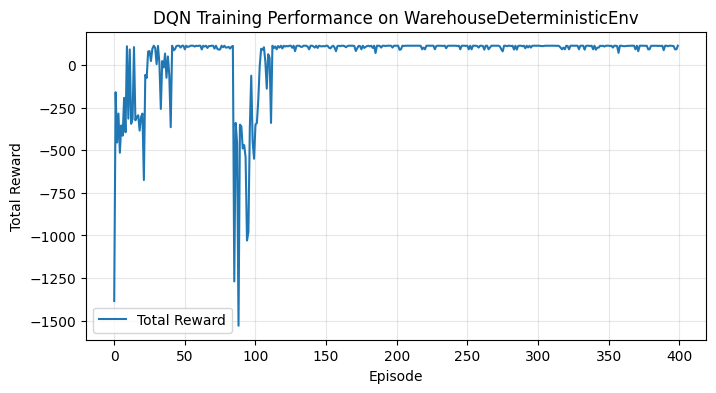

Final Epsilon: 0.050


In [ ]:
plt.figure(figsize=(8,4))
plt.plot(reward_history, label='Total Reward')
plt.title("DQN Training Performance on WarehouseDeterministicEnv")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

print(f"Final Epsilon: {agent_dqn.epsilon:.3f}")



Evaluating trained agent (greedy policy):


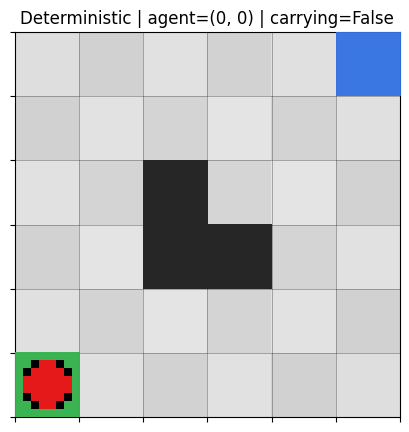

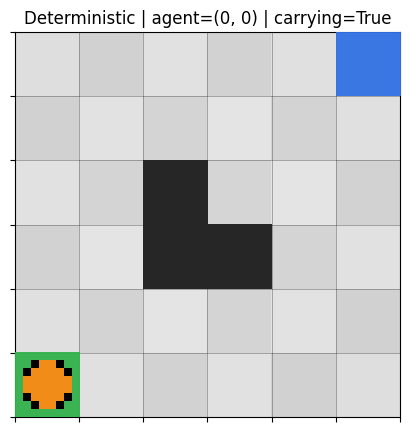

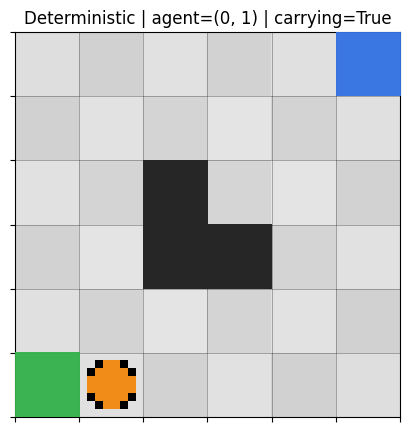

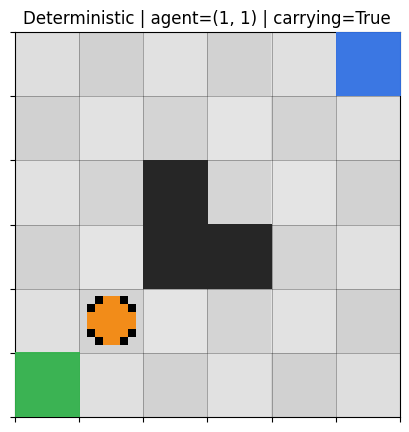

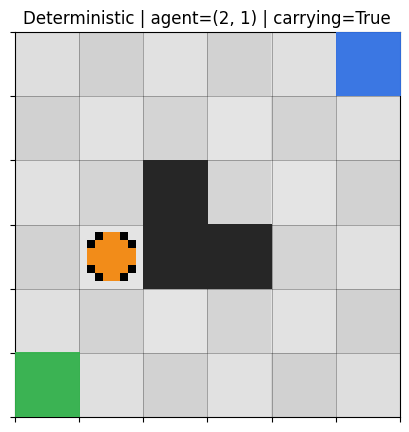

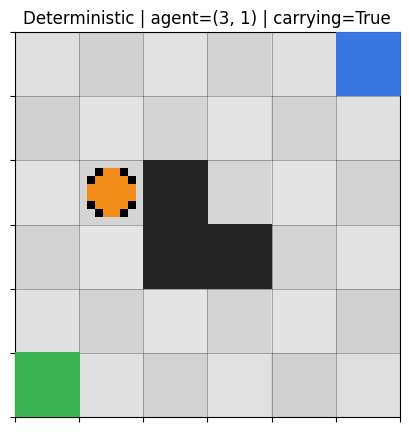

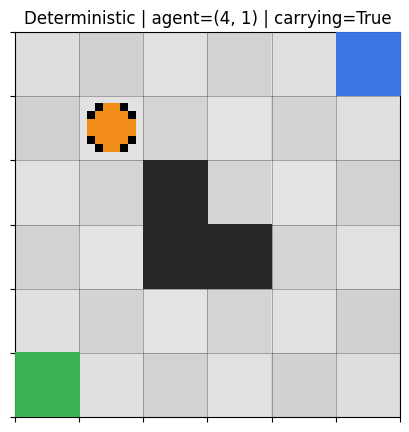

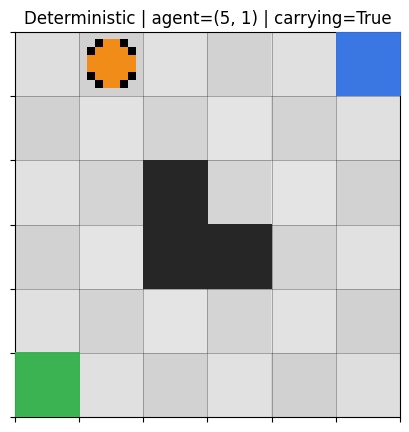

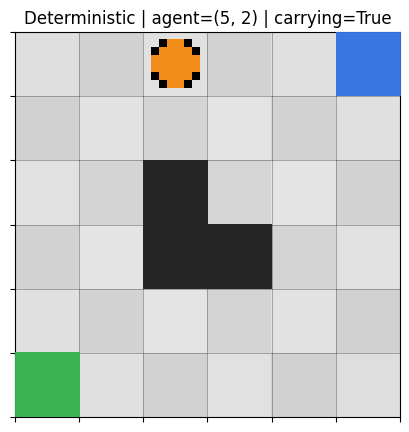

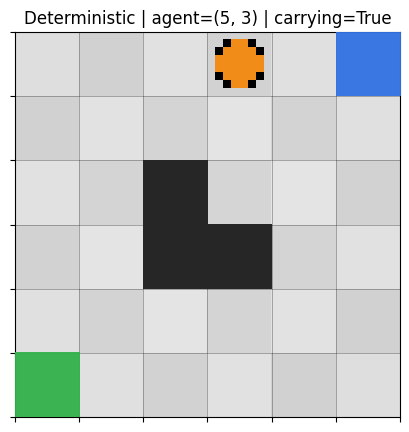

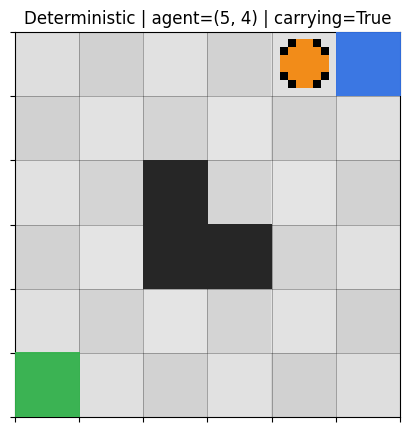

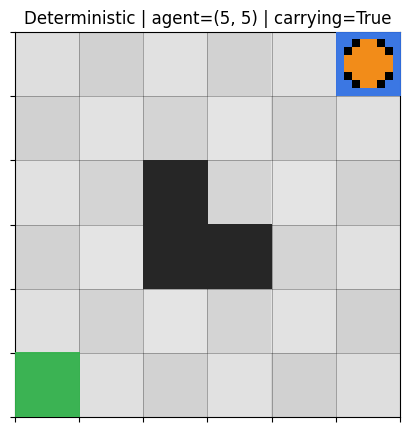

Total reward in evaluation: 113.0


In [ ]:
# Evaluate greedy policy after training
state, _ = env_dqn.reset()
done = False
ep_reward = 0

print("\nEvaluating trained agent (greedy policy):")

while not done:
    env_dqn.render()
    state_vec = one_hot_state_vector(state, state_size)
    with torch.no_grad():
        q_values = agent_dqn.net_main(state_vec)
        best_action = int(torch.argmax(q_values).item())
    next_state, reward, terminated, truncated, _ = env_dqn.step(best_action)
    done = terminated or truncated
    ep_reward += reward
    state = next_state

print(f"Total reward in evaluation: {ep_reward}")


In [ ]:
torch.save(agent_dqn.net_main.state_dict(), "a2_part_2_dqn_gridworld_hgowdarm_nsoni.pth")


## Part 2.2 – Applying DQN to Standard RL Environments
This section reuses the same DQN implementation on:
1. CartPole-v1
2. LunarLander-v2

In [5]:
class ContinuousDQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99,
                 eps_start=1.0, eps_min=0.05, eps_decay=0.995,
                 memory_size=50000, batch_size=64, target_update=1000):

        self.gamma = gamma
        self.epsilon = eps_start
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.target_update = target_update
        self.action_dim = action_dim

        self.q_main = DeepQBrain(state_dim, action_dim)
        self.q_target = DeepQBrain(state_dim, action_dim)
        self.q_target.load_state_dict(self.q_main.state_dict())
        self.q_target.eval()

        self.optim = optim.Adam(self.q_main.parameters(), lr=lr)
        self.memory = ExperienceStorage(max_len=memory_size)
        self.learn_counter = 0

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        s_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q_vals = self.q_main(s_t)
        return int(torch.argmax(q_vals).item())

    def store(self, s, a, r, s2, done):
        self.memory.add((s, a, r, s2, done))

    def update(self):
        if len(self.memory) < self.batch_size:
            return

        s, a, r, s2, d = self.memory.sample_batch(self.batch_size)
        s = torch.tensor(s, dtype=torch.float32)
        a = torch.tensor(a, dtype=torch.long)
        r = torch.tensor(r, dtype=torch.float32)
        s2 = torch.tensor(s2, dtype=torch.float32)
        d = torch.tensor(d, dtype=torch.float32)

        q_pred = self.q_main(s).gather(1, a.unsqueeze(1)).squeeze(1)
        q_next = self.q_target(s2).detach().max(1)[0]
        q_target = r + self.gamma * q_next * (1 - d)

        loss = F.mse_loss(q_pred, q_target)
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()

        self.learn_counter += 1
        if self.learn_counter % self.target_update == 0:
            self.q_target.load_state_dict(self.q_main.state_dict())

        if self.epsilon > self.eps_min:
            self.epsilon *= self.eps_decay


In [6]:
def train_env(env_name, episodes=500, max_steps=500):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = ContinuousDQNAgent(state_dim, action_dim)
    rewards = []

    for ep in range(1, episodes + 1):
        s, _ = env.reset()
        total_r = 0
        for t in range(max_steps):
            a = agent.act(s)
            s2, r, term, trunc, _ = env.step(a)
            done = term or trunc
            agent.store(s, a, r, s2, done)
            agent.update()
            s = s2
            total_r += r
            if done:
                break
        rewards.append(total_r)
        if ep % 25 == 0:
            print(f"{env_name} | Episode {ep}/{episodes} | Reward: {total_r:.1f} | ε={agent.epsilon:.3f}")

    env.close()
    return agent, rewards


CartPole-v1 | Episode 25/800 | Reward: 11.0 | ε=0.188
CartPole-v1 | Episode 50/800 | Reward: 10.0 | ε=0.050
CartPole-v1 | Episode 75/800 | Reward: 9.0 | ε=0.050
CartPole-v1 | Episode 100/800 | Reward: 9.0 | ε=0.050
CartPole-v1 | Episode 125/800 | Reward: 9.0 | ε=0.050
CartPole-v1 | Episode 150/800 | Reward: 10.0 | ε=0.050
CartPole-v1 | Episode 175/800 | Reward: 10.0 | ε=0.050
CartPole-v1 | Episode 200/800 | Reward: 10.0 | ε=0.050
CartPole-v1 | Episode 225/800 | Reward: 42.0 | ε=0.050
CartPole-v1 | Episode 250/800 | Reward: 75.0 | ε=0.050
CartPole-v1 | Episode 275/800 | Reward: 10.0 | ε=0.050
CartPole-v1 | Episode 300/800 | Reward: 198.0 | ε=0.050
CartPole-v1 | Episode 325/800 | Reward: 229.0 | ε=0.050
CartPole-v1 | Episode 350/800 | Reward: 139.0 | ε=0.050
CartPole-v1 | Episode 375/800 | Reward: 126.0 | ε=0.050
CartPole-v1 | Episode 400/800 | Reward: 157.0 | ε=0.050
CartPole-v1 | Episode 425/800 | Reward: 189.0 | ε=0.050
CartPole-v1 | Episode 450/800 | Reward: 163.0 | ε=0.050
CartPole-

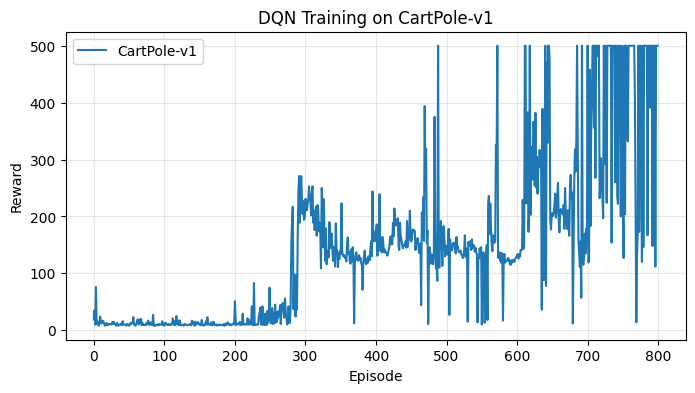

 Saved CartPole model.


In [8]:
agent_cart, rewards_cart = train_env("CartPole-v1", episodes=800)

plt.figure(figsize=(8,4))
plt.plot(rewards_cart, label="CartPole-v1")
plt.xlabel("Episode"); plt.ylabel("Reward")
plt.title("DQN Training on CartPole-v1")
plt.grid(alpha=0.3); plt.legend()
plt.show()

torch.save(agent_cart.q_main.state_dict(), "a2_part_2_dqn_cartpole_hgowdarm_nsoni.pth")
print(" Saved CartPole model.")


In [9]:
env_eval = gym.make("CartPole-v1", render_mode="human")
scores = []

for ep in range(5):
    s, _ = env_eval.reset()
    done, score = False, 0
    while not done:
        s_t = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            a = torch.argmax(agent_cart.q_main(s_t)).item()
        s, r, term, trunc, _ = env_eval.step(a)
        done = term or trunc
        score += r
    scores.append(score)
    print(f"Greedy Eval {ep+1}: Reward = {score}")

env_eval.close()
print("Average Greedy Reward (CartPole):", np.mean(scores))


Greedy Eval 1: Reward = 500.0
Greedy Eval 2: Reward = 500.0
Greedy Eval 3: Reward = 500.0
Greedy Eval 4: Reward = 500.0
Greedy Eval 5: Reward = 500.0
Average Greedy Reward (CartPole): 500.0


In [10]:
!pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.2 MB/s eta 0:00:00


In [11]:
!pip install "gymnasium[box2d]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2409502 sha256=cb05331af75a0c8c5c9275d71bb48f12e97f00c6821b635a761c72d446072cec
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [ ]:
import gymnasium as gym
env = gym.make("LunarLander-v3")
print("State dim:", env.observation_space.shape[0])
print("Action dim:", env.action_space.n)
env.close()


State dim: 8
Action dim: 4


LunarLander-v3 | Episode 25/700 | Reward: -259.6 | ε=0.050
LunarLander-v3 | Episode 50/700 | Reward: -133.8 | ε=0.050
LunarLander-v3 | Episode 75/700 | Reward: -127.3 | ε=0.050
LunarLander-v3 | Episode 100/700 | Reward: -179.9 | ε=0.050
LunarLander-v3 | Episode 125/700 | Reward: -110.5 | ε=0.050
LunarLander-v3 | Episode 150/700 | Reward: 14.4 | ε=0.050
LunarLander-v3 | Episode 175/700 | Reward: 6.9 | ε=0.050
LunarLander-v3 | Episode 200/700 | Reward: 25.3 | ε=0.050
LunarLander-v3 | Episode 225/700 | Reward: -10.1 | ε=0.050
LunarLander-v3 | Episode 250/700 | Reward: 76.6 | ε=0.050
LunarLander-v3 | Episode 275/700 | Reward: 87.3 | ε=0.050
LunarLander-v3 | Episode 300/700 | Reward: 49.6 | ε=0.050
LunarLander-v3 | Episode 325/700 | Reward: 10.7 | ε=0.050
LunarLander-v3 | Episode 350/700 | Reward: -22.0 | ε=0.050
LunarLander-v3 | Episode 375/700 | Reward: 66.3 | ε=0.050
LunarLander-v3 | Episode 400/700 | Reward: 78.0 | ε=0.050
LunarLander-v3 | Episode 425/700 | Reward: 88.5 | ε=0.050
LunarL

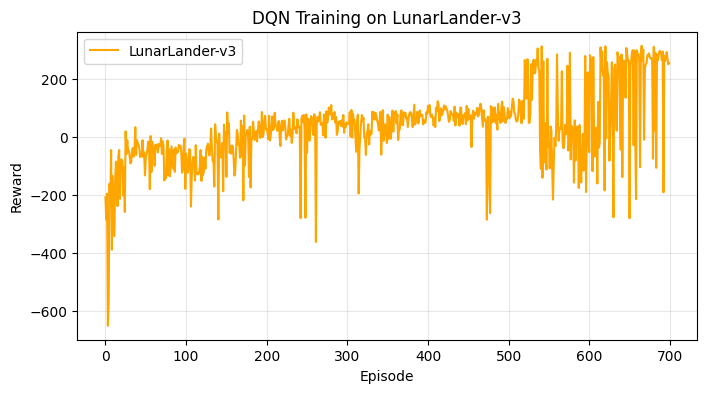

 Saved LunarLander model.


In [ ]:
agent_land, rewards_land = train_env("LunarLander-v3", episodes=700)

plt.figure(figsize=(8,4))
plt.plot(rewards_land, color='orange', label="LunarLander-v3")
plt.xlabel("Episode"); plt.ylabel("Reward")
plt.title("DQN Training on LunarLander-v3")
plt.grid(alpha=0.3); plt.legend()
plt.show()

torch.save(agent_land.q_main.state_dict(), "a2_part_2_dqn_lander_hgowdarm_nsoni.pth")
print(" Saved LunarLander model.")


In [ ]:
print("\nSummary:")
print(f"CartPole Avg Reward (Last 50 eps): {np.mean(rewards_cart[-50:]):.2f}")
print(f"LunarLander Avg Reward (Last 50 eps): {np.mean(rewards_land[-50:]):.2f}")




Summary:
CartPole Avg Reward (Last 50 eps): 170.18
LunarLander Avg Reward (Last 50 eps): 201.64


In [13]:
# import gymnasium as gym
# import numpy as np
import imageio
from IPython.display import Video, display

def record_episode(agent, env_name, filename="dqn_eval.mp4", max_steps=1000):
    env = gym.make(env_name, render_mode="rgb_array")
    s, _ = env.reset()
    frames = []
    total_reward = 0

    for t in range(max_steps):
        s_t = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            a = torch.argmax(agent.q_main(s_t)).item()
        s, r, term, trunc, _ = env.step(a)
        total_reward += r
        frame = env.render()
        frames.append(frame)
        if term or trunc:
            break

    env.close()
    print(f"Total Reward: {total_reward:.1f}")
    imageio.mimsave(filename, frames, fps=30)
    display(Video(filename, embed=True))

In [14]:
record_episode(agent_cart, "CartPole-v1", filename="cartpole_dqn.mp4")


Total Reward: 500.0


In [ ]:
record_episode(agent_land, "LunarLander-v3", filename="lander_dqn.mp4")


Total Reward: 293.9
